In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import seaborn as sns


In [2]:
directory = "./face_age/face_age_image" 

image_size = (200, 200)
batch_size = 16
validation_split = 0.2
seed = 42

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    seed=seed,
    image_size=image_size,
    labels="inferred",
    shuffle=True,
)

Found 4549 files belonging to 41 classes.


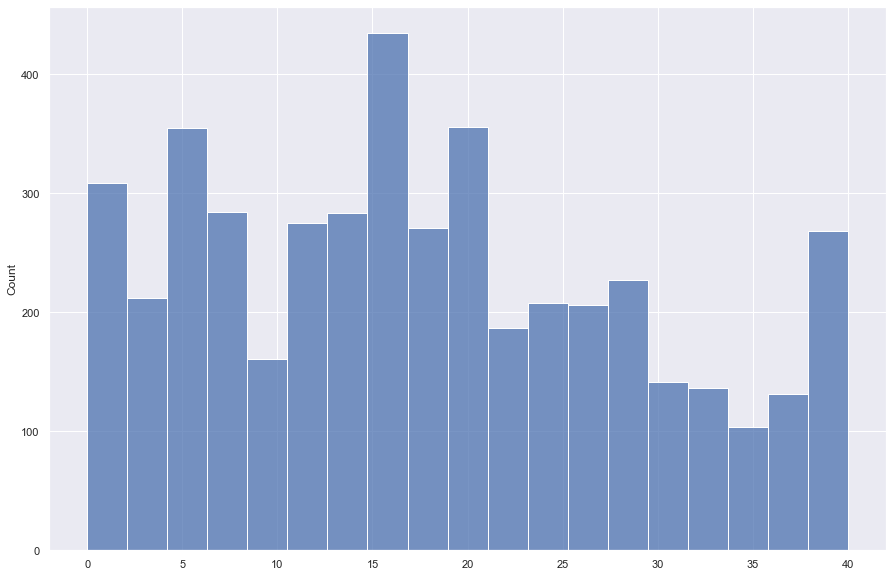

In [3]:
sns.set(rc={"figure.figsize":(15, 10)})

sns.histplot(x=np.concatenate([y for x, y in dataset], axis=0))
plt.show()

In [4]:
labels = np.concatenate([y for x, y in dataset], axis=0)
hist = {}
for label in labels:
    if not label in hist.keys():
        hist[label] = 1
    else:
        hist[label] += 1
h = [(k,v) for k,v in hist.items()]
h.sort(key=lambda x: x[0])
target = 900
bin = 0
goal =[]
l = []
for a,b in h:
    bin += b
    l.append(a)
    if bin > target:
        goal.append(l)
        bin = 0
        l = []
goal.append(l)
print(goal)
print(len(goal))
num_classes = len(goal)

[[0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], [16, 17, 18, 19, 20, 21], [22, 23, 24, 25, 26, 27, 28, 29, 30], [31, 32, 33, 34, 35, 36, 37, 38, 39, 40]]
5


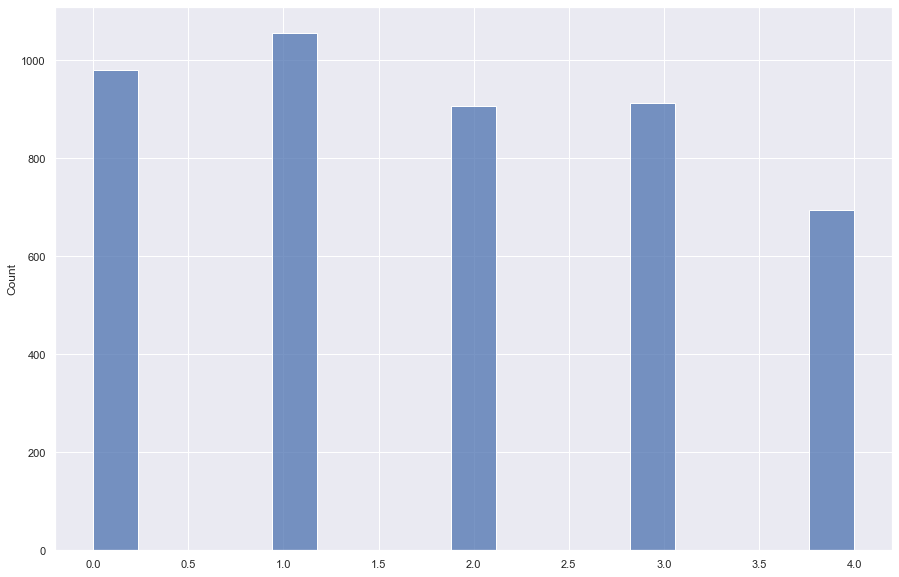

(4549, 5)


In [5]:
assign = {}
for idx, x in enumerate(goal):
    for y in x:
        assign[y] = idx
new_labels = []
for label in labels:
    new_labels.append(assign[label])
sns.histplot(x=new_labels)
plt.show()
new_labels = np.asarray(new_labels)
cat_labels = np.zeros((new_labels.size, new_labels.max()+1))
cat_labels[np.arange(new_labels.size), new_labels] = 1
print(cat_labels.shape)

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split=validation_split,
    subset='training',
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    labels=cat_labels.tolist(),
    shuffle=True,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split=validation_split,
    subset='validation',
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    labels=cat_labels.tolist(),
    shuffle=True,
)

Found 4549 files belonging to 41 classes.
Using 3640 files for training.
Found 4549 files belonging to 41 classes.
Using 909 files for validation.


In [11]:
model = Sequential()
model.add(layers.InputLayer(input_shape=(200, 200, 3)))

# 1st conv block
model.add(layers.Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model.add(layers.MaxPool2D(pool_size=(2, 2), padding='same'))
# 2nd conv block
model.add(layers.Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model.add(layers.MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(layers.BatchNormalization())
# 3rd conv block
model.add(layers.Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model.add(layers.MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(layers.BatchNormalization())
# ANN block
model.add(layers.Flatten())
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dropout(0.25))
# output layer
model.add(layers.Dense(units=5, activation='softmax'))
model.summary()

model.compile(optimizer='adamax',loss='categorical_crossentropy',metrics=['accuracy'])

# train the model
model.fit(train_ds,epochs=10,validation_data=val_ds)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 200, 200, 25)      1900      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 100, 100, 25)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 50, 50)        31300     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 25, 25, 50)       0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Batc  (None, 25, 25, 50)       200       
 hNormalization)                                                 
                                                      

In [12]:
prediction = model.predict(val_ds)
prediction = prediction.argmax(axis=1)

In [15]:
val_labels = np.concatenate([y for x, y in val_ds], axis=0).argmax(axis=1)

In [16]:
print(prediction.shape)
print(val_labels.shape)

(909,)
(909,)


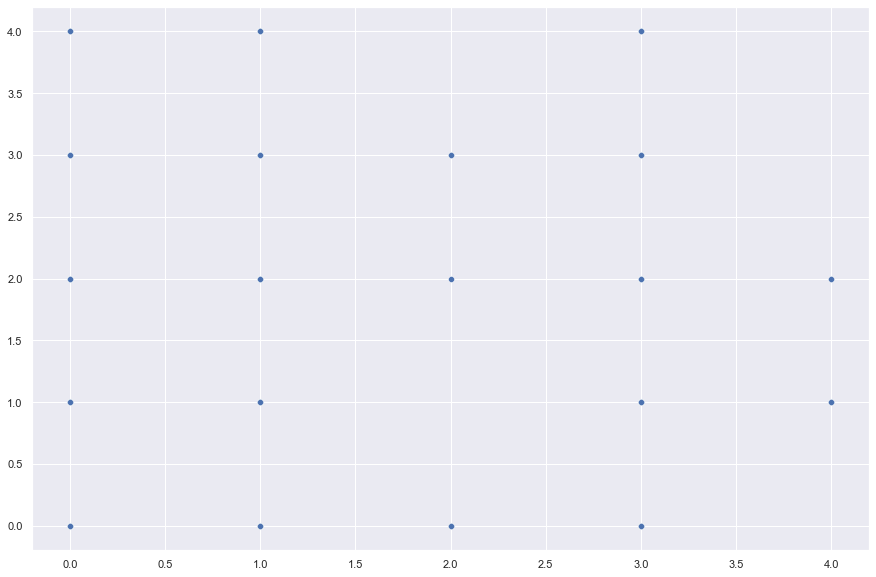

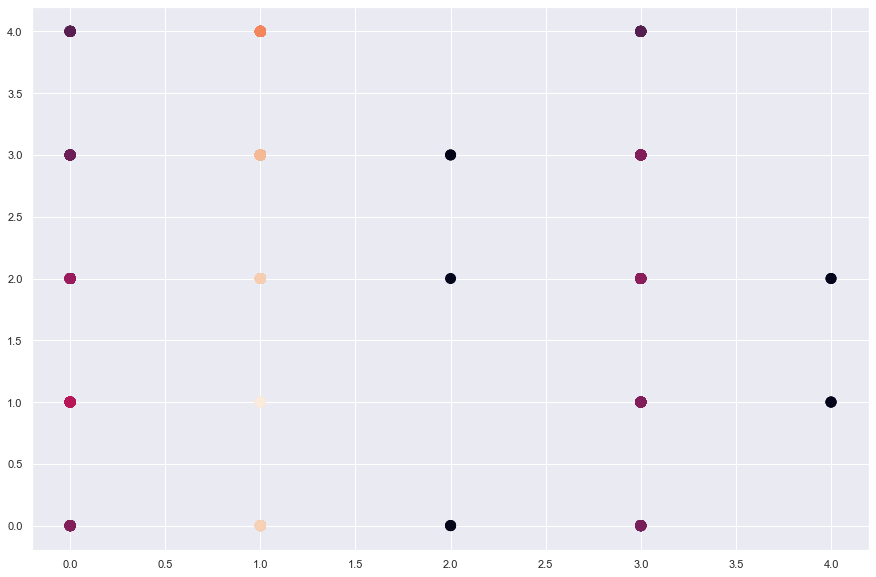

In [17]:
from scipy.stats import gaussian_kde

sns.scatterplot(x=prediction, y=val_labels)

XY = np.vstack([prediction, val_labels])
z = gaussian_kde(XY)(XY)
fig, ax = plt.subplots()
ax.scatter(x=prediction, y=val_labels, c=z, s=100)
plt.show()